In [3]:
DATA_PATH = "data/UrbanSound8K"
PROCESSED_DATA_PATH = "data/2d_processed"

In [4]:
import pandas as pd
import os.path
import librosa as lr
import librosa.display as lrdsp
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras


In [5]:
def load_info():
    """Loads the csv file to a numpy table.
     
    | filename | salience | fold | classID |
    """
    csv = pd.read_csv(os.path.join(DATA_PATH, "UrbanSound8K.csv"))
    csv = csv.drop(labels=["fsID", "start", "end", "class"], axis=1)
    csv = csv.to_numpy()
    return csv

def load_file_index(csv, index):
    """Load the wav file at `csv[index]`, return the wave, sr, and classID."""
    path = os.path.join(DATA_PATH, "fold{}".format(csv[index][2]), csv[index][0])
    wave, sr = lr.load(path)
    class_id = csv[index][3]
    return (wave, sr, class_id)

def load_file_row(csv_row):
    """Load the wav file at `csv[index]`, return the wave, sr, and classID."""
    path = os.path.join(DATA_PATH, "fold{}".format(csv_row[2]), csv_row[0])
    wave, sr = lr.load(path)
    class_id = csv_row[3]
    return (wave, sr, class_id)

classes = [
    "air_conditioning",
    "car_horn",
    "children_playing",
    "dog_bark",
    "drilling",
    "engine_idling",
    "gunshot",
    "jackhammer",
    "siren",
    "street_music",
]

In [6]:
csv = load_info()

# TODO: print some info

In [7]:
INPUT_SHAPE = (173, 128)
def preprocess(wave, sr):
    spec = lr.feature.melspectrogram(wave, sr=sr, n_mels=INPUT_SHAPE[1])
    spec = lr.power_to_db(spec)
    # we repeat the spectrogram to make every input equally long
    spec = np.pad(spec, ((0,0),(0,INPUT_SHAPE[0]-spec.shape[1])), mode="wrap")
    spec = np.transpose(spec)
    return spec

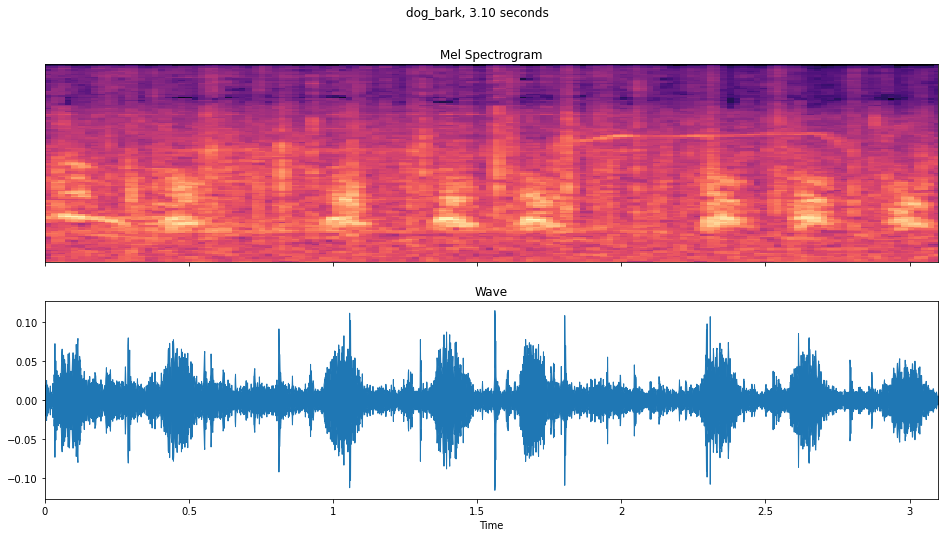

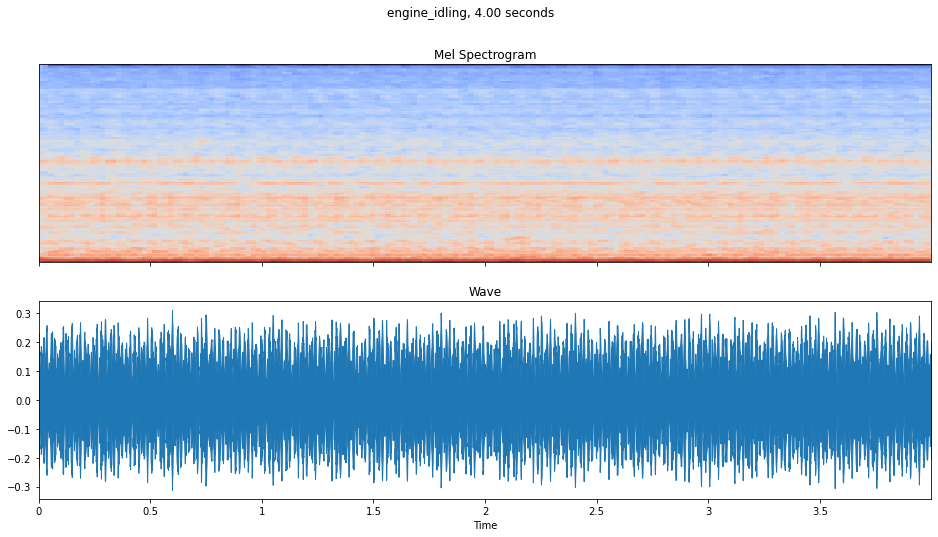

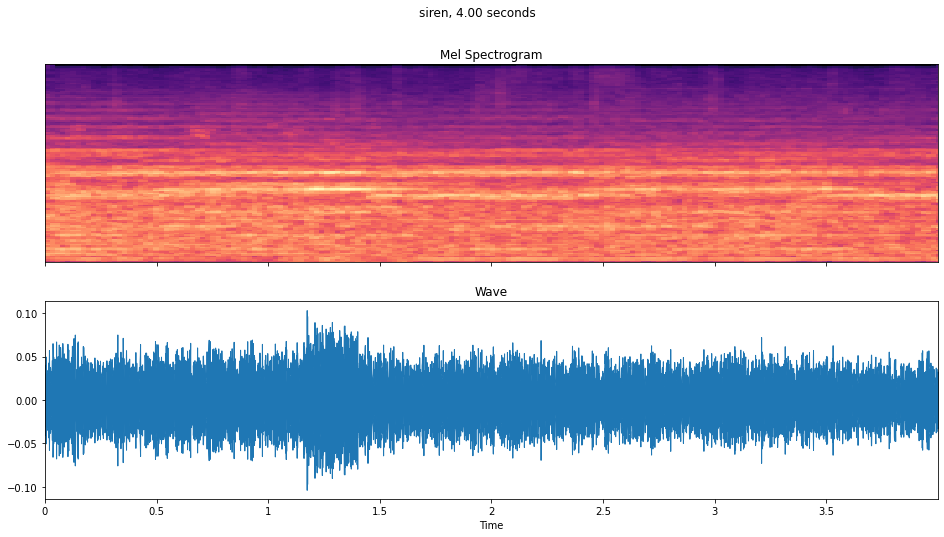

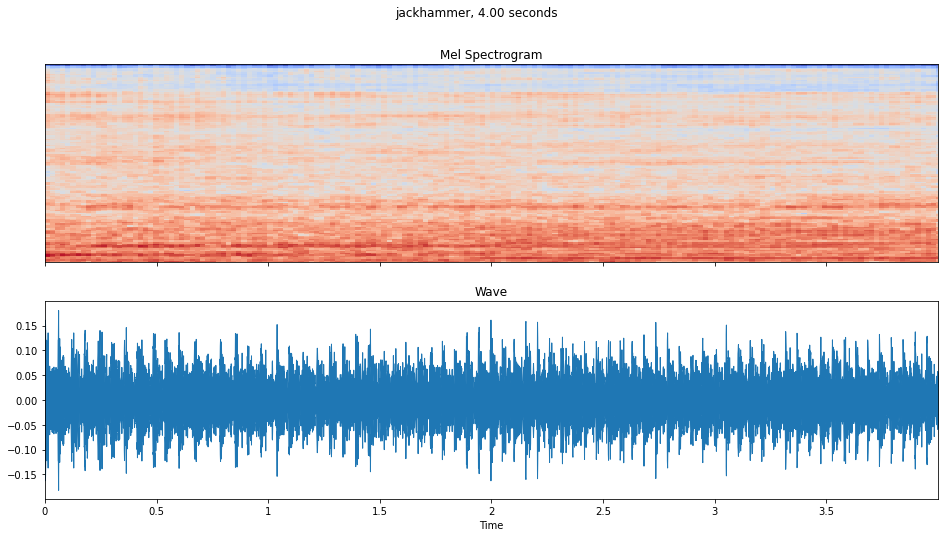

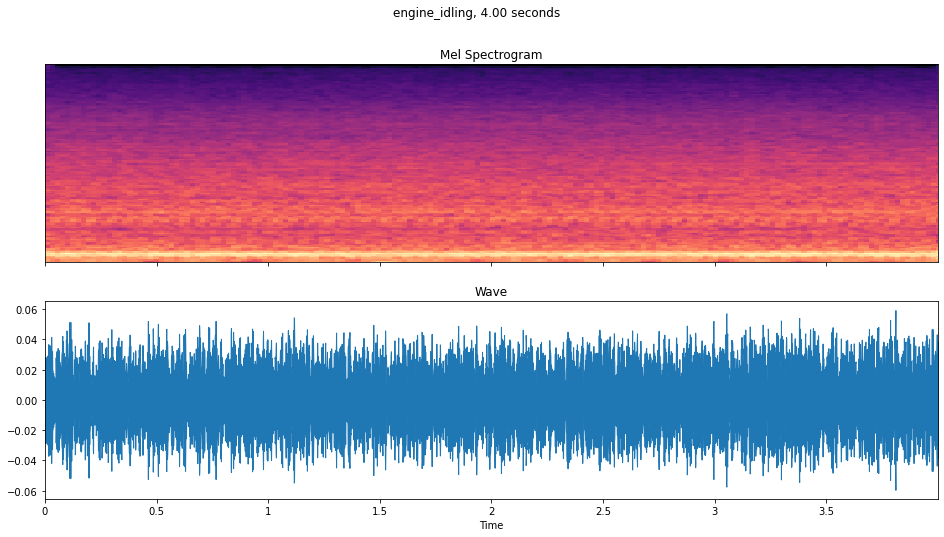

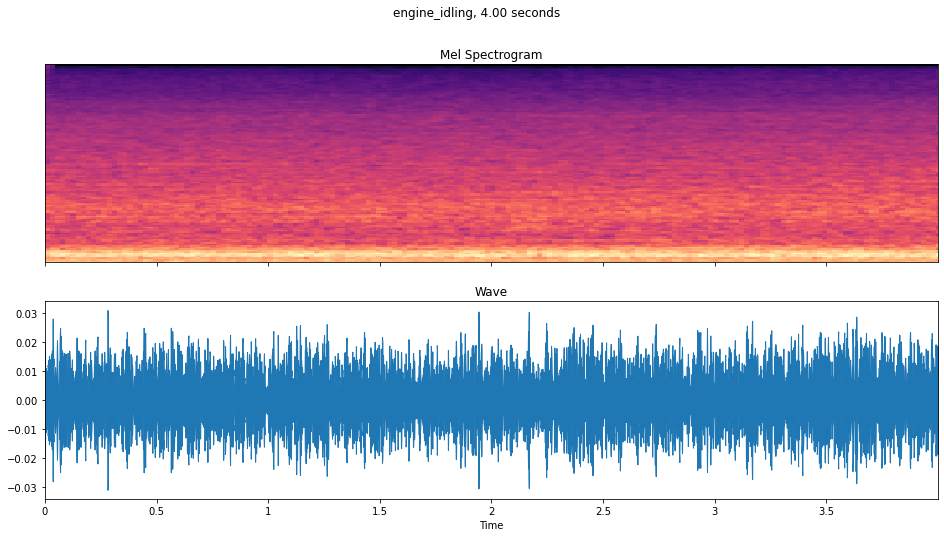

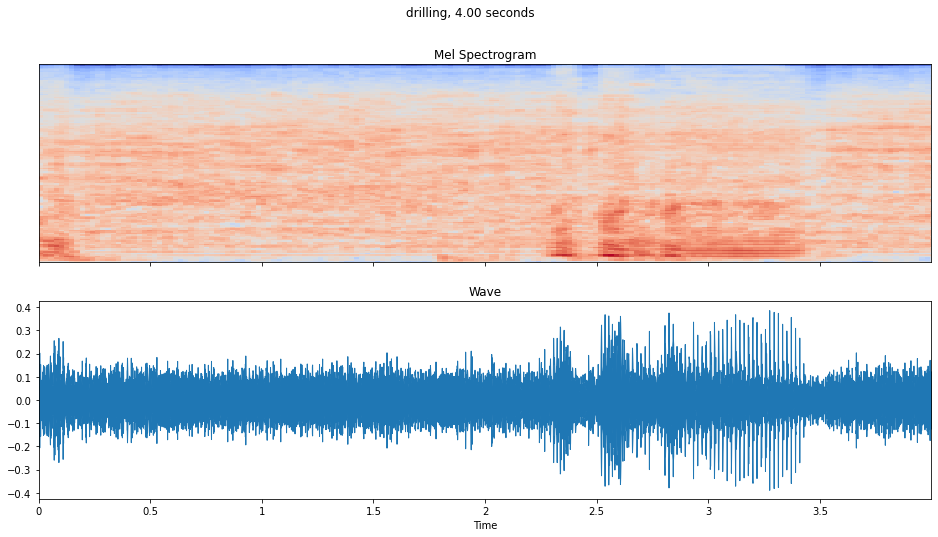

In [8]:
for i in range(100,300,30):
    wave, sr, c = load_file_index(csv, i)
    spec = np.transpose(preprocess(wave, sr))

    fig, ax = plt.subplots(nrows=2, figsize=(16,8), sharex=True)
    fig.suptitle("{}, {:.2f} seconds".format(classes[c], len(wave)/sr))

    lrdsp.specshow(spec, sr=sr, ax=ax[0], x_axis="time")
    ax[0].set(title="Mel Spectrogram")
    ax[0].label_outer()

    lrdsp.waveplot(wave, sr=sr, ax=ax[1], x_axis="time")
    ax[1].set(title="Wave")
    

We load in preprocessed data, or create it if necessary.

In [9]:
X_folds = np.empty((0,873,INPUT_SHAPE[0],INPUT_SHAPE[1]))
y_folds = np.empty((0,873))
if not os.path.exists(PROCESSED_DATA_PATH):
    print("Preprocessing data, this will take some time...")
    os.mkdir(PROCESSED_DATA_PATH)
    for i in range(1,11):
        fold_csv = csv[csv[:,2]==1]
        print("Fold {}, {} files:".format(i, len(fold_csv)))
        X = np.empty((0,INPUT_SHAPE[0], INPUT_SHAPE[1]))
        y = np.empty(0)
        for j, row in enumerate(fold_csv):
            wave, sr, c = load_file_row(row)
            
            data = preprocess(wave, sr)

            X = np.append(X, data[np.newaxis], axis=0)
            y = np.append(y, c)
            print(".", end="", flush=True)
            if (j+1) % 100 == 0:
                print("")
    
        np.savez(os.path.join(PROCESSED_DATA_PATH, "fold{}".format(i)), X=X, y=y)
        print("\nStored fold{} data in {}".format(i, os.path.join(PROCESSED_DATA_PATH, "fold{}.npz".format(i))))

        X_folds = np.append(X_folds, X[np.newaxis], axis=0)
        y_folds = np.append(y_folds, y[np.newaxis], axis=0)

else:
    print("Processed data directory found, proceeding to read it in...")
    for i in range(1,11):
        data = np.load(os.path.join(PROCESSED_DATA_PATH, "fold{}.npz".format(i)))
        print(".", end="", flush=True)

        X_folds = np.append(X_folds, data["X"][np.newaxis], axis=0)
        y_folds = np.append(y_folds, data["y"][np.newaxis], axis=0)

Processed data directory found, proceeding to read it in...
..........

Now we define how our model should work.

In [10]:
# from keras.layers

def build_model():
    keras.backend.clear_session()

    model = keras.models.Sequential()
    # model.add(keras.layers.LSTM(128, input_shape=INPUT_SHAPE, return_sequences=True))
    # model.add(keras.layers.GRU(512, input_shape=INPUT_SHAPE, return_sequences=True))
    # model.add(keras.layers.GRU(256, input_shape=INPUT_SHAPE))
    model.add(keras.layers.LSTM(256, input_shape=INPUT_SHAPE))

    # Dense layers
    # model.add(keras.layers.Dense(512, activation="sigmoid"))
    # model.add(keras.layers.Dense(128, activation="sigmoid"))
    model.add(keras.layers.Dense(512, activation="sigmoid"))
    model.add(keras.layers.Dense(128, activation="sigmoid"))
    model.add(keras.layers.Dense(10, activation="softmax"))

    model.compile(
        optimizer=keras.optimizers.Adam(5e-4), 
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"]
    )

    return model

BATCH_SIZE = 24

build_model().summary()




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 512)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 592,778
Trainable params: 592,778
Non-trainable params: 0
_________________________________________________________________


And we test it on a single train-test split, just so we can see some quick results:

In [13]:
t = 8

X_train = np.concatenate(np.append(X_folds[:t], X_folds[t+1:], axis=0))
y_train = keras.utils.to_categorical(np.concatenate(np.append(y_folds[:t], y_folds[t+1:], axis=0)))
X_test = X_folds[t]
y_test = keras.utils.to_categorical(y_folds[t])

model = build_model()

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    verbose=1,
    validation_data=(X_test, y_test),
    shuffle=True,
)


Train on 7857 samples, validate on 873 samples
Epoch 1/20
7857/7857 [==============================] - 306s 39ms/sample - loss: 1.4363 - acc: 0.5493 - val_loss: 0.9661 - val_acc: 0.7297
Epoch 2/20
7857/7857 [==============================] - 294s 37ms/sample - loss: 0.7402 - acc: 0.8071 - val_loss: 0.5941 - val_acc: 0.8488
Epoch 3/20
7857/7857 [==============================] - 295s 38ms/sample - loss: 0.5076 - acc: 0.8679 - val_loss: 0.3856 - val_acc: 0.8866
Epoch 4/20
7857/7857 [==============================] - 289s 37ms/sample - loss: 0.3554 - acc: 0.9086 - val_loss: 0.3405 - val_acc: 0.9038
Epoch 5/20
7857/7857 [==============================] - 294s 37ms/sample - loss: 0.3104 - acc: 0.9124 - val_loss: 0.3631 - val_acc: 0.8992
Epoch 6/20
7857/7857 [==============================] - 283s 36ms/sample - loss: 0.2764 - acc: 0.9175 - val_loss: 0.2561 - val_acc: 0.9221
Epoch 7/20
7857/7857 [==============================] - 276s 35ms/sample - loss: 0.2561 - acc: 0.9264 - val_loss: 0.183

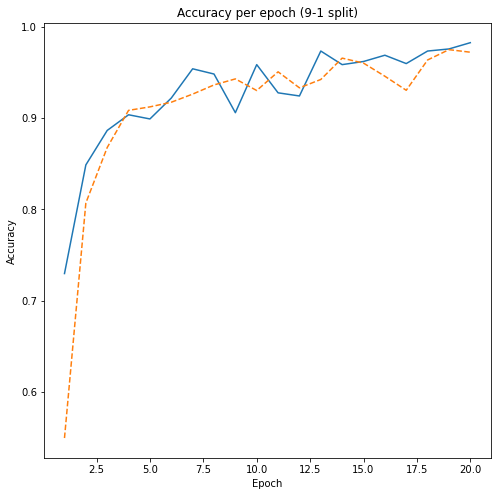

In [16]:
plt.figure(figsize=(8,8))
plt.title("Accuracy per epoch (9-1 split)")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
for i in range(1):
    plt.plot(range(1,21), history.history["val_acc"], color="tab:blue", label="Test")
    plt.plot(range(1,21),history.history["acc"], color="tab:orange", linestyle="dashed", label="Train")